In [106]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import json
import numpy as np

### Define configurations
Define all the constants and configurations to be used for the data acquisition, including:
- Data directories
    - To Json files created in step 1
    - To png files to be created in this steps for the visualization
- naming of Json files created in step 1
- Start & end date in format `YYYYMM`

In [173]:
json_dir = 'data/jsons'
png_dir = 'data/pngs'
startYYYYMM = "201507"
endYYYYMM = "202409"
name_template = {
    'mobile': f'rare-disease_monthly_mobile_{startYYYYMM}-{endYYYYMM}.json',
    'desktop': f'rare-disease_monthly_desktop_{startYYYYMM}-{endYYYYMM}.json',
    # 'all-access': f'rare-disease_monthly_cumulative_{startYYYYMM}-{endYYYYMM}.json'
}

### Define function to proccess JSON files

In [174]:
def process_file(file_path, access_type):
    """
    Process a single file and add the access type (desktop or mobile).
    
    Parameters:
    - file_path (str): Path to the JSON file
    - access_type (str): 'desktop' or 'mobile'
    
    Returns:
    - pd.DataFrame: A pandas DataFrame with the processed data and 'access' column added.
    """
    # Load the JSON file into a list of dictionaries
    with open(file_path, 'r') as file:
        data = json.load(file)
    
    # Convert list of dicts into a DataFrame
    df = pd.DataFrame(data)
    
    # Add a column for 'access' if not present
    if 'access' not in df.columns:
        df['access'] = access_type
    
    return df



Proccess multiple JSON files & concat them into 1 single DataFrame for further steps.
Convert the `timestamp` column from `str` type to `datetime` type

In [203]:


df = pd.DataFrame()

for access_type, file_name in name_template.items():
    print(access_type, file_name)
    file_path = os.path.join(json_dir, file_name)
    df = pd.concat([df, process_file(file_path, access_type)])
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y%m%d%H')
df

mobile rare-disease_monthly_mobile_201507-202409.json
desktop rare-disease_monthly_desktop_201507-202409.json


,project,article,granularity,timestamp,agent,views,access
0,en.wikipedia,Klinefelter_syndrome,monthly,2015-07-01,user,38513,mobile
1,en.wikipedia,Klinefelter_syndrome,monthly,2015-08-01,user,34903,mobile
2,en.wikipedia,Klinefelter_syndrome,monthly,2015-09-01,user,33557,mobile
3,en.wikipedia,Klinefelter_syndrome,monthly,2015-10-01,user,36000,mobile
4,en.wikipedia,Klinefelter_syndrome,monthly,2015-11-01,user,39945,mobile
...,...,...,...,...,...,...,...
191412,en.wikipedia,Chronic_lung_disease,monthly,2024-05-01,user,9,desktop
191413,en.wikipedia,Chronic_lung_disease,monthly,2024-06-01,user,20,desktop
191414,en.wikipedia,Chronic_lung_disease,monthly,2024-07-01,user,21,desktop
191415,en.wikipedia,Chronic_lung_disease,monthly,2024-08-01,user,22,desktop


### Visualization 1: Maximum Average and Minimum Average

This graphs contains time series for the articles that have the highest average page requests and the lowest average page requests for desktop access and mobile access over the entire time series.

Compute the average views for each type of access and article.
Identify the articles with the min and max mean views for each access type and stores their time series of views in the dictionary `stat_dict` for the first plot./
This cell does this by:
1. Groups the DataFrame `df` by `access` and `article` columns and calculates the average of `views`.
2. Creates a plot to visualize the time series of articles with the minimum and maximum average views for each access type.
    a. The x-axis is the time (unit: year)
    b. Y-axis is the views
3. Save figure to png file

mobile min: Filippi_Syndrome, 1.588235294117647
mobile max: Black_Death, 177697.84684684683
desktop min: Filippi_Syndrome, 3.6176470588235294
desktop max: Black_Death, 104859.31531531531


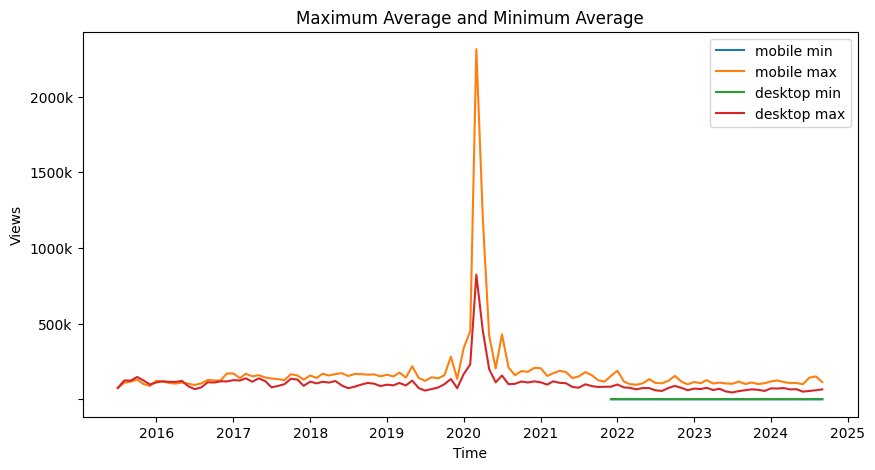

In [311]:


groupby = df.groupby(['access','article'])['views'].mean()
fig, ax = plt.subplots(figsize=(10, 5))

for access_type, _ in name_template.items():
    access_argmin = groupby[access_type].idxmin()
    access_argmax = groupby[access_type].idxmax()

    print(f"{access_type} min: {access_argmin}, {groupby[access_type].min()}")
    print(f"{access_type} max: {access_argmax}, {groupby[access_type].max()}")

    argmin_time_series = df.loc[(df['access']==access_type) & (df['article']==access_argmin)] \
                            .sort_values(by='timestamp', ascending=True)[['timestamp','views']]

    argmax_time_series = df.loc[(df['access']==access_type) & (df['article']==access_argmax)] \
                            .sort_values(by='timestamp', ascending=True)[['timestamp','views']]
    
    ax.plot(argmin_time_series['timestamp'], argmin_time_series['views'], label=f"{access_type} min")
    ax.plot(argmax_time_series['timestamp'], argmax_time_series['views'], label=f"{access_type} max")

ax.set_xlabel('Time')
ax.set_ylabel('Views')
ax.set_title('Maximum Average and Minimum Average')
# Set the y-ticks and formatter on the ax
def thousands_formatter(x, pos):
    if x == 0:
        return ''
    return f'{int(x / 1000)}k'
ax.yaxis.set_major_formatter(mtick.FuncFormatter(thousands_formatter))

ax.legend()
fig_dir = os.path.join(png_dir, 'max_min_average.png')
fig.savefig(fig_dir)
plt.show()

Note that not all articles have all the months available.

### Visualization 2: Top 10 Peak Page Views 

This graph contains time series for the top 10 article pages by largest (peak) page views over the entire time series by access type.

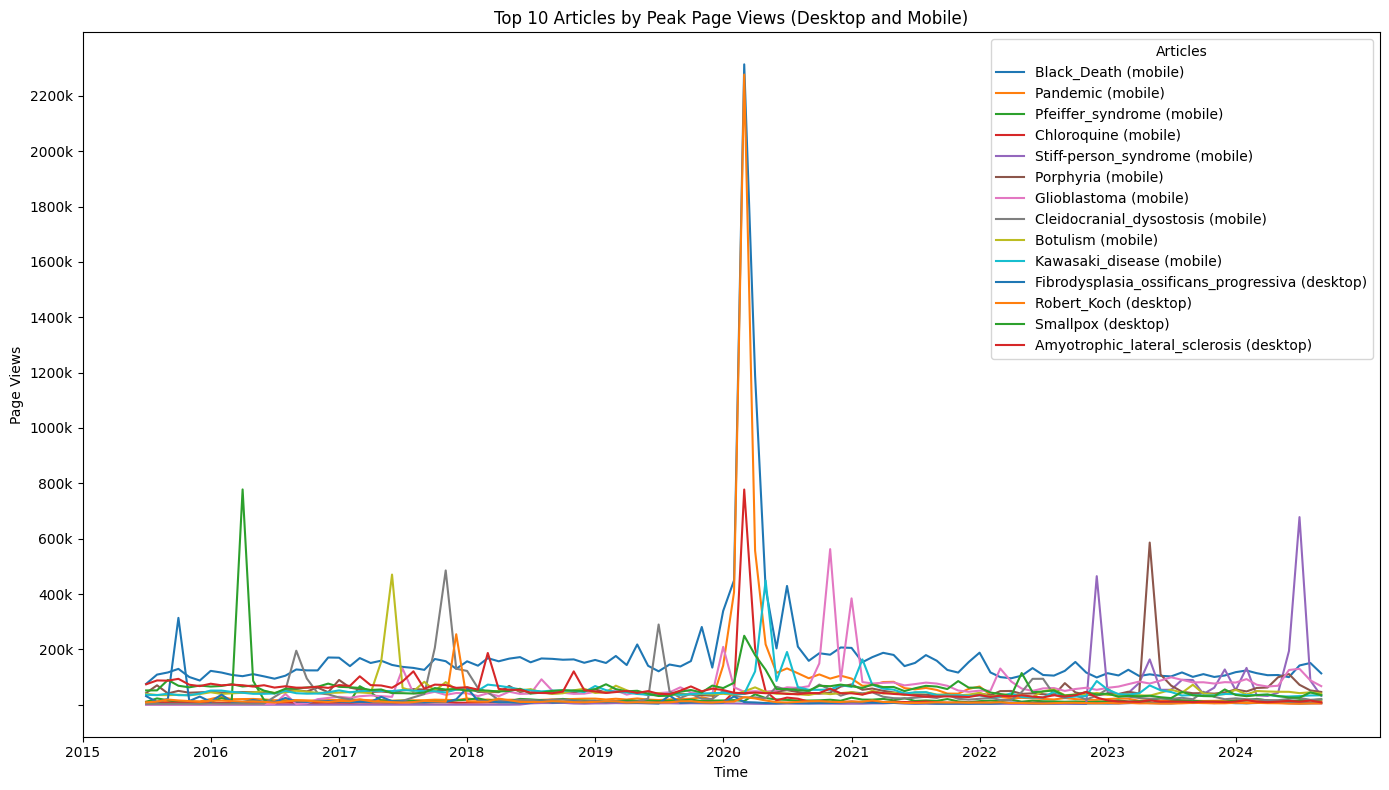


Top 10 Articles by Peak Page Views:

Access Type Article                                  Peak Views  
------------------------------------------------------
desktop    Pandemic                                 1046521     
desktop    Black_Death                              823649      
desktop    Chloroquine                              440897      
desktop    Pfeiffer_syndrome                        408153      
desktop    Fibrodysplasia_ossificans_progressiva    313785      
desktop    Botulism                                 302593      
desktop    Robert_Koch                              254656      
desktop    Smallpox                                 249177      
desktop    Cleidocranial_dysostosis                 191115      
desktop    Amyotrophic_lateral_sclerosis            186945      
------------------------------------------------------
mobile     Black_Death                              2313741     
mobile     Pandemic                                 2276916     
mobile

In [310]:
def plot_top_articles_by_peak_views(df, save_name, verbose=True):
    """
    This function plots the top 10 articles by peak page views for desktop and mobile access types.

    Parameters:
    df (pd.DataFrame): The DataFrame with the data
    save_name (str): The name of the file to save the plot
    verbose (bool): Whether to print the top 10 articles by peak page views (optional, default is True)

    Returns:
    None
    """
    peak_views_df = df.groupby(['article', 'access'])['views'].max().reset_index()

    # Find the top 10 articles by peak views for each access type
    top_mobile = peak_views_df[peak_views_df['access'] == 'mobile'] \
                  .nlargest(10, 'views')
    top_desktop = peak_views_df[peak_views_df['access'] == 'desktop'] \
                   .nlargest(10, 'views')
    top_articles = pd.concat([top_mobile, top_desktop])

    # Create a new figure
    plt.figure(figsize=(14, 8))

    # Plot time series for the top articles
    for article in top_articles['article'].unique():
        article_df = df[(df['article'] == article) & (df['access'] == top_articles[top_articles['article'] == article]['access'].values[0])]
        plt.plot(article_df['timestamp'], article_df['views'], label=f"{article} ({article_df['access'].values[0]})")

    # Set y-ticks in thousands
    max_y_range = int(df['views'].max())
    plt.yticks(range(0, max_y_range, 200000))
    def thousands_formatter(x, pos):
        if x == 0:
            return ''
        return f'{int(x / 1000)}k'
    plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(thousands_formatter))

    plt.title('Top 10 Articles by Peak Page Views (Desktop and Mobile)')
    plt.xlabel('Time')
    plt.ylabel('Page Views')

    # X-axis ticks to show years
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y%m%d%H')
    years = pd.date_range(start=df['timestamp'].min()- pd.offsets.YearEnd(), end=(df['timestamp'].max()), freq='YS')
    plt.xticks(ticks=years, labels=[dt.year for dt in years])

    plt.legend(title="Articles" , loc='upper right')
    plt.tight_layout()
    plt.savefig(save_name)
    plt.show()

    if verbose:
        print("\nTop 10 Articles by Peak Page Views:\n")
        print(f"{'Access Type':<10} {'Article':<40} {'Peak Views':<12}")
        print("-" * 54)

        # Print desktop top 10
        for index, row in top_desktop.iterrows():
            print(f"{row['access']:<10} {row['article']:<40} {row['views']:<12}")
        print("-" * 54)
        
        # Print mobile top 10
        for index, row in top_mobile.iterrows():
            print(f"{row['access']:<10} {row['article']:<40} {row['views']:<12}")

# Call the function with the DataFrame
full_path = os.path.join(png_dir, 'top_10_articles.png')
plot_top_articles_by_peak_views(df, full_path)

### Visualization 3: Fewest Months of Data

This third shows pages that have the fewest months of available data. The graph only shows the 10 articles with the fewest months of data for desktop access and the 10 articles with the fewest months of data for mobile access.

This cell processes the DataFrame `df` to extract and analyze the number of unique months 
each article has been accessed, grouped by access type by:
1. Extract the year and month from the `timestamp` column in `dt` type and store it in a new column `month`.
2. Count the number of unique months each article has been accessed for each `access` type.
3. Identify the 10 articles with the fewest months for each access type.
4. Combine the results into a single DataFrame `fewest_months_df`.

In [266]:
# Extract year and month from timestamp
df['month'] = df['timestamp'].dt.to_period('M')

# Count unique months for each article by access type
month_counts = df.groupby(['access', 'article'])['month'].nunique()
fewest_months_df = pd.DataFrame(columns=['article', 'month', 'access'])

for access_type in df['access'].unique():
    fewest_months_access_df = month_counts[access_type].nsmallest(10) 
    fewest_months_access_df = fewest_months_access_df.reset_index()
    fewest_months_access_df['access'] = access_type

    fewest_months_df = pd.concat([fewest_months_df, fewest_months_access_df])

fewest_months_df


,article,month,access
0,Retinal_vasculopathy_with_cerebral_leukoenceph...,33,mobile
1,Filippi_Syndrome,34,mobile
2,COVID-19_vaccine_misinformation_and_hesitancy,37,mobile
3,CDKL5_deficiency_disorder,40,mobile
4,Joseph_Vinetz,40,mobile
5,Bradley_Monk,41,mobile
6,Deaf_plus,41,mobile
7,Hemolytic_jaundice,41,mobile
8,Spongy_degeneration_of_the_central_nervous_system,41,mobile
9,Ellis–Van_Creveld_syndrome,44,mobile


This cell generates 2 bar plots for the fewest months of data for mobile and desktop accesses.
This function creates a figure with two subplots, each representing the fewest months of data for a specific access type (mobile or desktop). The bars in each subplot represent the number of months of data available for different articles. The function also saves the generated plot as a PNG file.

C:\Users\nguye\AppData\Local\Temp\ipykernel_11112\2735038778.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(subset_df['article'], rotation=90, ha='right')
C:\Users\nguye\AppData\Local\Temp\ipykernel_11112\2735038778.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(subset_df['article'], rotation=90, ha='right')
C:\Users\nguye\AppData\Local\Temp\ipykernel_11112\2735038778.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


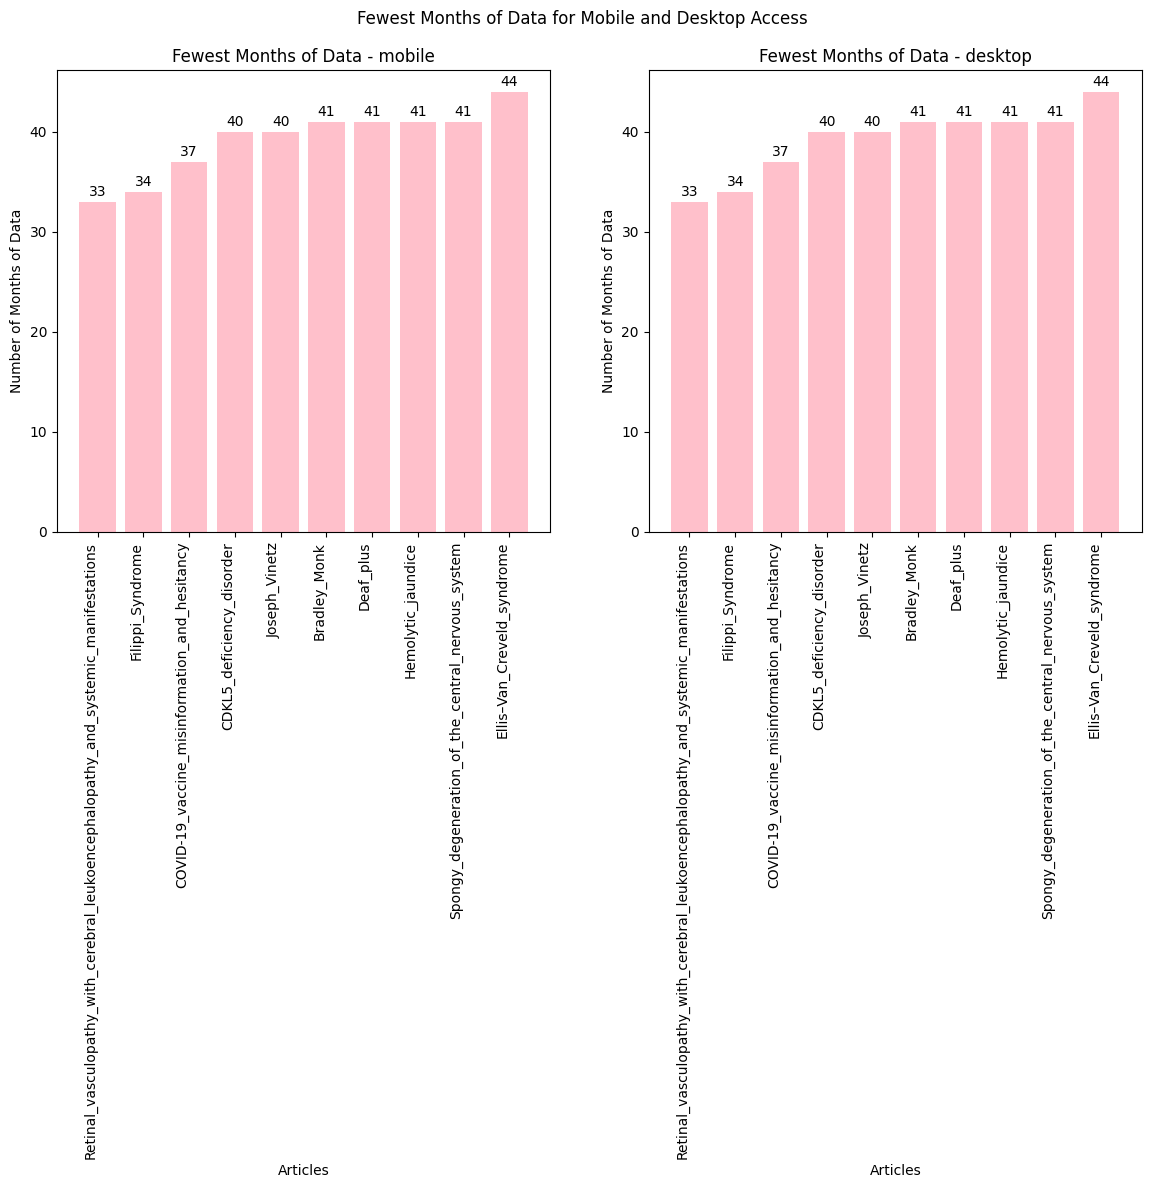

In [308]:
bar_width = 0.35

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
accesses = fewest_months_df['access'].unique()

for i in range(len(accesses)):
    subset_df = fewest_months_df[fewest_months_df['access'] == accesses[i]]
    index = np.arange(len(subset_df))
    axs[i].bar(index, subset_df['month'], color='pink')
    axs[i].set_title(F'Fewest Months of Data - {accesses[i]}')
    axs[i].set_xlabel('Articles')
    axs[i].set_ylabel('Number of Months of Data')
    axs[i].set_xticklabels(subset_df['article'], rotation=90, ha='right')
    axs[i].set_xticks(index)
    for j, value in enumerate(subset_df['month']):
        axs[i].text(j, value + 0.3, str(value), ha='center', va='bottom')

fig.suptitle('Fewest Months of Data for Mobile and Desktop Access')
full_path = os.path.join(png_dir, 'fewest_months.png')
fig.savefig(full_path)
plt.tight_layout()
plt.show()